#Exercício em Python - Tema 4 - Balanço Hídrico

O Brasil é um país com dimensões continentais, e apresenta grande diversidade de biomas e climas. Por essas características, é observado grandes variações nos regimes chuvosos, temperaturas e formação do solo  nas regiões do território nacional.   Portanto, pensando nessas características citadas, realize o balanço hídrico nas 5 bacias hidrográficas que estão descritas na tabela 01 e discorra sobre os efeitos da localização geográfica e do uso e ocupação na disponibilidade hídrica.

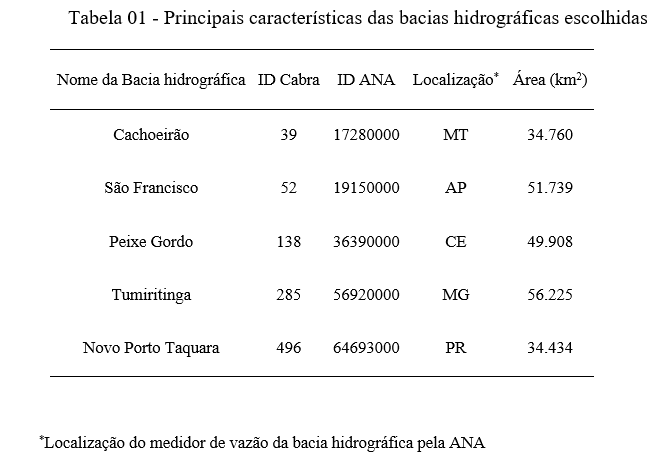

##1. Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import requests, io

##2. Importar dados CABra

In [2]:
# Bacias escolhidas representando diferentes biomas/regionais hidrográficas
bacias = ['39', '52', '138', '285', '496']
nomes_bacias = {
    '39': 'Cachoeirao',
    '52': 'Sao Francisco',
    '138': 'Peixe Gordo',
    '285': 'Tumiritinga',
    '496': 'Novo Porto Taquara'
}

variaveis = {
    'tmin': 'Temperatura Mínima (C)',
    'tmax': 'Temperatura Máxima (C)',
    'p': 'Precipitação (mm)',
    'pet_pm': 'Evapotranspiração Potencial (mm)'
}

# Dicionário para armazenar os DataFrames por bacia
dfs = {}

In [ ]:
# Etapa 1: Importação e agregação anual sem função
i = 0
for b in bacias:
    url = f"https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_climate_daily_series/ens/CABra_{b}_climate_ENS.txt"
    r = requests.get(url).content
    df = pd.read_csv(io.StringIO(r.decode('utf-8', errors='ignore')), skiprows=13, delimiter='\t')
    df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']
    #Exclui linha 0 pois não faz parte dos dados
    df = df.drop([0], axis=0)
    #Passando todos os dados para categoria numérica
    df = df.apply(pd.to_numeric)
    #Definir coluna de data
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    #Calculando a media e soma dos valores ao longo dos anos
    df_mes = df.groupby(['year', 'month']).agg({
        'tmin': 'mean',
        'tmax': 'mean',
        'p': 'sum',
        'pet_pm': 'sum',
        'et': 'sum'
    }).reset_index()
    #Calculando a media mensal climatica das bacias
    df_mes = df_mes.groupby('month')[['tmin', 'tmax', 'p', 'pet_pm', 'et']].mean().reset_index()
    dfs[b] = df_mes
    i += 1

#Meses do ano
meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']

In [96]:
#Escolhendo uma das bacias para o cálculo
bacia = '39'

##3. Gráfico de barras de precipitação nos meses do ano

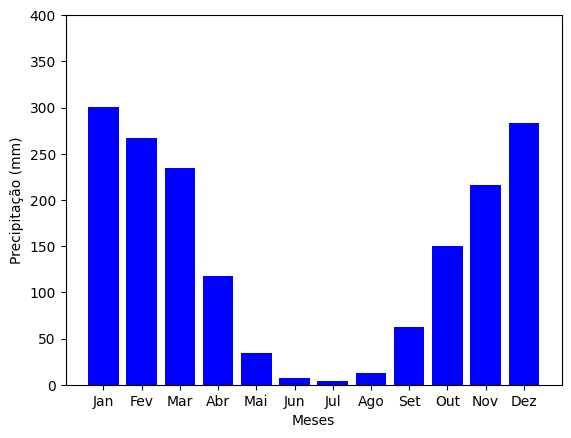

In [97]:
#Plotagem
plt.bar(meses, dfs[bacia]['p'], color="blue")
plt.ylim([0.0, 400])
plt.xlabel('Meses')
plt.ylabel('Precipitação (mm)')
plt.show()

##4. Evapotranspiração

O cálculo da Evapotranspiração divide-se em 2 tipos: Evapotranspiração Potencial (ETP ou ET0), que seria a perda da água por evaporação e transpiração caso não houvessem limites de água no ambiente; e Evapotranspiração Real (ET), que é a que de fato ocorre nas condições ambientais vigentes no local. A ETP nunca será menor que a ET. Vamos ver em nossos exemplos a comparação das médias mensais das duas.

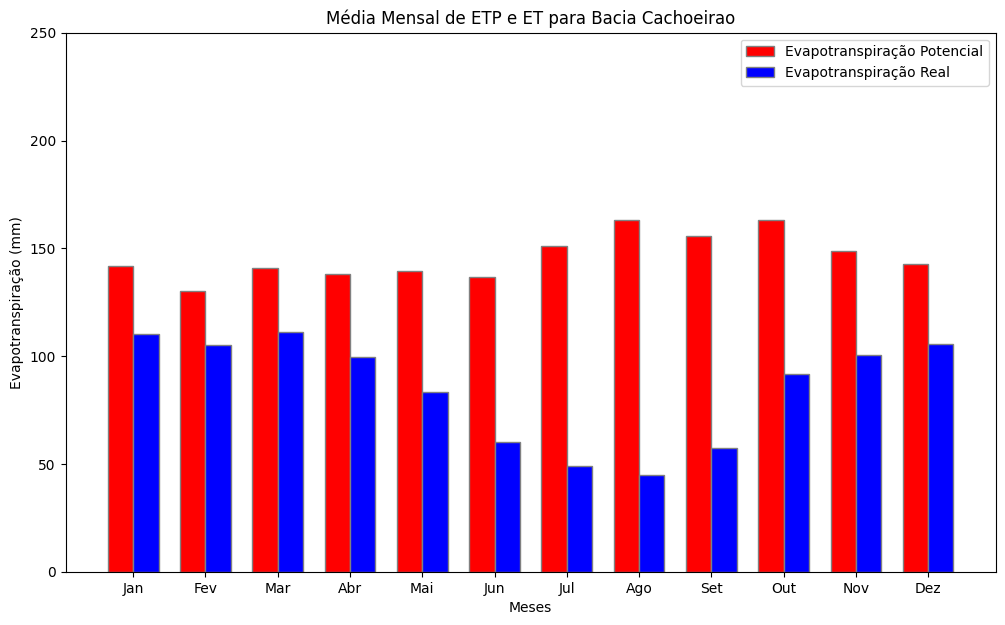

In [50]:
#Plotagem
bar_width = 0.35
r1 = np.arange(len(meses))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 7))
plt.bar(r1, dfs[bacia]['pet_pm'], color='red', width=bar_width, edgecolor='grey', label='Evapotranspiração Potencial')
plt.bar(r2, dfs[bacia]['et'], color='blue', width=bar_width, edgecolor='grey', label='Evapotranspiração Real')

plt.xlabel('Meses')
plt.ylabel('Evapotranspiração (mm)')
plt.xticks([r + bar_width/2 for r in range(len(meses))], meses)
plt.ylim([0.0, 250])
plt.xlabel('Meses')
plt.ylabel('Evapotranspiração (mm)')
plt.title(f"Média Mensal de ETP e ET para Bacia {nomes_bacias[bacia]}")
plt.legend()
plt.show()

##5. Índice de Aridez

In [36]:
#média da precipitacao
media_prec= np.mean(dfs[bacia]['p'])
#média de Evapotranspiração potencial (mm)  por Penman-Monteith
media_Evap= np.mean(dfs[bacia]['pet_pm'])
#calculo Indice de aridez
IA = media_prec/media_Evap

print ("O Índice de Aridez é: ",IA)

O Índice de Aridez é:  0.9643425862456141


##6. Escoamento Superficial

In [ ]:
# Etapa 1: Importação da base de dados
url = "https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_attributes/CABra_soil_attributes.txt"
r = requests.get(url).content
df = pd.read_csv(io.StringIO(r.decode('utf-8', errors='ignore')), skiprows=9, delimiter='\t')

df.columns = ['CABra ID','ANA ID','soil_type','soil_textclass','soil_sand','soil_silt','soil_clay',
              'soil_carbon','soil_bulk','soil_depth']

# Etapa 2: Classificação por argila (soil_clay)
cond_clay = [
    df['soil_clay'] > 40,
    df['soil_clay'].between(20, 40),
    df['soil_clay'].between(10, 20),
    df['soil_clay'] <= 10
]
grupo_clay = ['D', 'C', 'B', 'A']
df['soil_group_clay'] = np.select(cond_clay, grupo_clay, default='Unknown')

# Etapa 3: Classificação por areia (soil_sand)
cond_sand = [
    df['soil_sand'] >= 90,
    df['soil_sand'].between(50, 89.999),
    (df['soil_sand'] < 50) & (df['soil_group_clay'] == 'C'),
    (df['soil_sand'] < 50) & (df['soil_group_clay'] == 'D')
]
grupo_sand = ['A', 'B', 'C', 'D']
df['soil_group_sand'] = np.select(cond_sand, grupo_sand, default='Unknown')

# Etapa 4: Classificação por classe textural (soil_textclass)
textclass_map = {
    'SANDY CLAY': 'B',
    'SANDY LOAM': 'B',
    'CLAY LOAM': 'C',
    'LOAM': 'C',
    'SANDY CLAY LOAM': 'C',
    'CLAY': 'D'
}
df['soil_group_textclass'] = df['soil_textclass'].str.strip().map(textclass_map).fillna('D')

# Etapa 5: Grupo final (prioriza consenso, senão usa textclass)
def definir_grupo_final(row):
    grupos = [row['soil_group_clay'], row['soil_group_sand'], row['soil_group_textclass']]
    if grupos.count(grupos[0]) >= 2:
        return grupos[0]
    elif grupos.count(grupos[1]) >= 2:
        return grupos[1]
    else:
        return grupos[2]

df['soil_group_final'] = df.apply(definir_grupo_final, axis=1)

# Etapa 6: Mostrar solo da bacia específica
id_bacia = 39  # example, using the first basin from your list 'bacias'
grupo = df.loc[df['CABra ID'] == id_bacia, 'soil_group_final']
if not grupo.empty:
    print(f"O tipo de solo da sua bacia é: {grupo.values[0]}")
else:
    print("ID de bacia não encontrado.")

O tipo de solo da sua bacia é: D


Além disso, precisamos definir o uso e ocupação do solo. A data de base CABra definir para cada bacia 11 tipos diferentes de uso e ocupação, entretanto, para utilizar as tabelas por exemplo de Collischonn e Dornelles (2015) precisamos agrupar algumas desses tipos de uso e ocupação do solo.

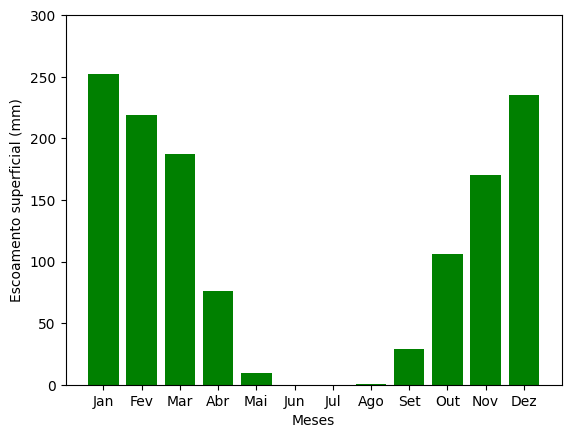

In [98]:
CN = 84.86
#Transformando o dataframe em array
P = dfs[bacia]['p'].tolist()
#Definido o array do escoamento superficial para inserção dos valores
Q = np.zeros(12)
#Maxima infiltracao acumulada potencial[S] = mm
S = 25400/CN - 254
#Perdas Inicias (Hipotese de 20% de S)
Ia = 0.2*S

#For para realizar o calculo para cada mes do ano
for j in range (len(P)):
  if (P[j]<=Ia):
    Q[j] = 0
  else:
    Q[j] = (P[j]-Ia)**2/(P[j]-Ia+S)

#Plotagem
plt.bar(meses, Q, color="green")
plt.ylim([0.0, 300])
plt.xlabel('Meses')
plt.ylabel('Escoamento superficial (mm)')
plt.show()

##7. Demanda

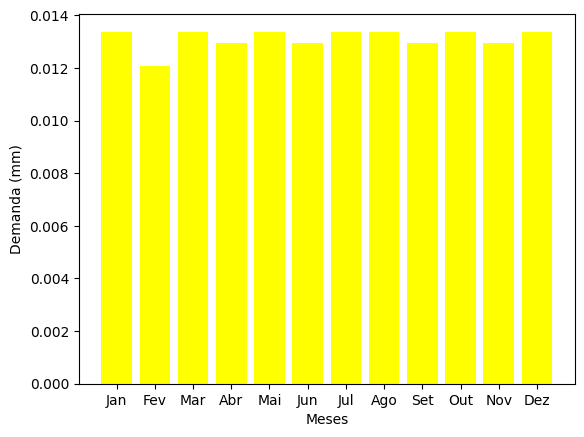

In [ ]:
#Importação da área da bacia
url = "https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_attributes/CABra_topography_attributes.txt"
r = requests.get(url).content
df_topo = pd.read_csv(io.StringIO(r.decode('utf-8', errors='ignore')), skiprows=8, delimiter='\t')

#Exclui linha 0 pois não faz parte dos dados
df_topo = df_topo.drop([0], axis=0)
# Nomeando as colunas
df_topo.columns = ['CABra ID','ANA ID','catch_area','elev_mean','elev_min','elev_max','elev_gauge','catch_slope','catch_order']
# Passando todos os dados para categoria numérica
df_topo = df_topo.apply(pd.to_numeric)

bacia_int = int(bacia)
area_km2 = df_topo.loc[df_topo['CABra ID'] == bacia_int, 'catch_area'].values[0]
area_m2 = area_km2 * 1000000

dias_meses = [31,28,31,30,31,30,31,31,30,31,30,31]
consumo_litros_mes = np.zeros(12)
demanda_mm = np.zeros(12)

#For para realizar o calculo para cada mes do ano, considerando 100.000 habitantes que consomem 150 litros por dia cada
for j in range (len(dias_meses)):
  consumo_litros_mes[j] = 150 * 100000 * dias_meses[j]
  demanda_mm[j] = consumo_litros_mes[j] / area_m2

#Plotagem
plt.bar(meses, demanda_mm, color="yellow")
plt.xlabel('Meses')
plt.ylabel('Demanda (mm)')
plt.show()

##8. Balanço Hídrico

Agora vamos calcular o Balanço Hídrico mensalmente. Para isso, vamos somar todas as entradas (precipitação) e saídas (escoamento superficial, evapotranspiração real e demanda de consumo) da bacia calculadas anteriormente pelas médias mensais.

In [94]:
# Calculo do Balanço Hídrico
bh = dfs[bacia]['p'] - dfs[bacia]['et'] - Q - demanda_mm

# Adicionar coluna de meses e verificação baseado no valor resultante de cada mês
bh_df = pd.DataFrame({'balanco_hidrico': bh})
bh_df['mes'] = meses
bh_df['verificacao'] = bh_df['balanco_hidrico'].apply(lambda x: 'Excesso' if x >= 0 else 'Déficit')
bh_df

,balanco_hidrico,mes,verificacao
0,-62.182277,Jan,Déficit
1,-57.431439,Fev,Déficit
2,-64.509238,Mar,Déficit
3,-58.730723,Abr,Déficit
4,-58.110997,Mai,Déficit
5,-52.720172,Jun,Déficit
6,-44.849410,Jul,Déficit
7,-32.269631,Ago,Déficit
8,-23.888628,Set,Déficit
9,-48.274820,Out,Déficit


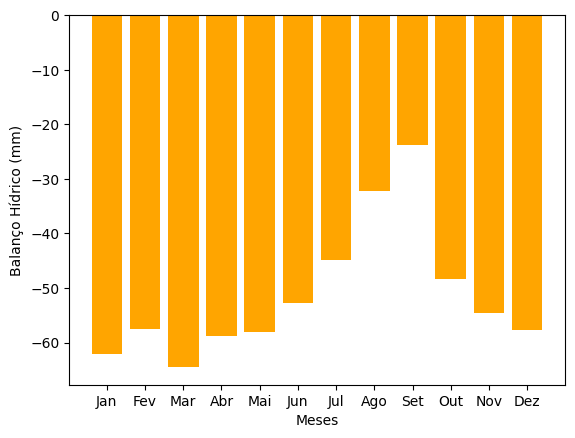

In [95]:
#Plotagem
plt.bar(meses, bh, color="orange")
plt.xlabel('Meses')
plt.ylabel('Balanço Hídrico (mm)')
plt.show()